- query llm to verify correctness of data inspection agent with respect to ground truth
- fusion node neccessity 

not yet
- looping back
- whole channel support

In [1]:
import os
import json
import base64
from typing import TypedDict, List, Dict, Any, Optional, Literal

import numpy as np

from dotenv import load_dotenv
import tiktoken

from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

from langgraph.graph import StateGraph, END
from openai import OpenAI

import tools  
from tools_schema import TOOLS_SCHEMAS

# ---------- 0. Token safeguards ----------

# Use GPT-4o tokenizer
enc = tiktoken.encoding_for_model("gpt-4o")


def prompt_to_text(prompt_obj):
    return prompt_obj.to_string() if hasattr(prompt_obj, "to_string") else str(prompt_obj)


def count_tokens(text: str) -> int:
    """Count tokens using GPT-4o tokenizer."""
    return len(enc.encode(text))


def enforce_token_limit(payload: str, max_tokens: int, context_name: str = "") -> str:
    """
    Ensures the payload stays under the token limit.
    Raises ValueError if it doesn't.
    """
    tok = count_tokens(payload)
    if tok > max_tokens:
        raise ValueError(
            f"[TOKEN LIMIT EXCEEDED in {context_name}] "
            f"Payload has {tok} tokens, exceeds limit of {max_tokens}. "
            f"Reduce numeric payload or increase reduction."
        )
    return payload


def safeguard_numeric_output(nr: Dict[str, Any], max_items: int = 20) -> Dict[str, Any]:
    safe = {}

    for k, v in nr.items():

        # Scalars: always safe
        if isinstance(v, (int, float, bool, type(None))):
            safe[k] = v

        # Small dict of scalars
        elif isinstance(v, dict):
            small = {}
            for kk, vv in v.items():
                if isinstance(vv, (int, float)):
                    small[kk] = vv
            safe[k] = small

        # Lists or arrays: REMOVE them
        elif isinstance(v, (list, tuple)):
            if len(v) <= max_items and all(isinstance(x, (int, float)) for x in v):
                safe[k] = v  # short scalar list allowed
            else:
                safe[k] = f"[REMOVED ARRAY length={len(v)}]"
        else:
            safe[k] = f"[UNSAFE TYPE REMOVED: {type(v)}]"

    return safe


# ---------- 0.1 Build Tools Catalog ----------


def build_tool_catalog_str() -> str:
    lines = []
    for t in TOOLS_SCHEMAS:
        lines.append(f"- {t['name']}: {t['description']}")
        params = t["parameters"]["properties"]
        if params:
            for pname, pinfo in params.items():
                desc = pinfo.get("description", "")
                default = pinfo.get("default", None)
                if default is not None:
                    lines.append(f"    - {pname} (default={default}): {desc}")
                else:
                    lines.append(f"    - {pname}: {desc}")
    return "\n".join(lines)


# ---------- 1. Pydantic models ----------

class ToolCall(BaseModel):
    tool: str = Field(
        description="Name of the tool from the tool catalog to call."
    )
    args: Dict[str, Any] = Field(
        default_factory=dict,
        description="Arguments for the tool. Do NOT include raw data or metadata; those are automatically provided."
    )
    rationale: str = Field(
        description="Explanation of why this tool was chosen and how the provided arguments support the analysis goal."
    )


class PlannerOutput(BaseModel):
    calls: List[ToolCall] = Field(
        description="Ordered list of planned tool calls the agent will execute."
    )
    checklist: List[str] = Field(
        description="A list of procedural checks or steps that must be completed to meet the user defined goal."
    )
    rationale: str = Field(
        description="High-level explanation for the full analysis plan and tool ordering."
    )


class ExecutionOutput(BaseModel):
    tools: List[Dict[str, Any]] = Field(
        description=(
            "A list where each element is: "
            "{ 'tool': str, 'numeric': dict or None, 'images': list of paths }"
        )
    )
    metadata: Dict[str, Any]


class Interpretation(BaseModel):
    findings: Dict[str, Any] = Field(
        description="Structured summary of insights extracted from execution outputs."
    )
    next_tools: List[ToolCall] = Field(
        default_factory=list,
        description="Optional recommendations for additional tool calls to refine or extend the analysis. Leave empty if no additional tools are needed."
    )
    rationale: str = Field(
        description="Explanation of how findings were reached and why specific next steps are recommended."
    )


class InspectionSummary(BaseModel):
    issues_detected: List[str] = Field(
        description="List of problems detected."
    )
    metrics: Dict[str, Any] = Field(
        description="Quantitative evaluation metrics relevant to data quality or tool performance."
    )
    visual_findings: List[str] = Field(
        description="Descriptions of notable visual features found in plots or images."
    )
    metadata_notes: List[str] = Field(
        description="Notes about metadata completeness, consistency, or anomalies."
    )
    final_summary: str = Field(
        description="Concise narrative integrating all inspection findings into a final assessment."
    )
    checklist_completed_rationale: str = Field(
        description="A concise rationale explaining whether all checklist items were completed. If yes, briefly state how each item was addressed; if no, identify which items were missed and why."
    )
    checklist_completed: bool = Field(
        description="Indicates whether all items from the planner's checklist were addressed."
    )


class InterpreterPrompts(BaseModel):
    image_prompt: str = Field(
        description="Prompt provided to the image-analysis interpreter model."
    )
    image_prompt_rationale: str = Field(
        description="Explanation for how the image prompt was constructed and why it is suitable."
    )
    numeric_prompt: str = Field(
        description="Prompt provided to the numeric-analysis interpreter."
    )
    numeric_prompt_rationale: str = Field(
        description="Reasoning behind the numeric prompt design and its alignment with analysis goals."
    )
    domain_prompt: str = Field(
        description="Prompt for the domain-specific scientific interpreter."
    )
    domain_prompt_rationale: str = Field(
        description="Explanation of how the domain prompt was structured to elicit expert-level insights."
    )


# ---------- 2. LangGraph state ----------

class InspectionState(TypedDict, total=False):
    # static inputs
    goal: str
    raw_data: List[float]
    metadata: Dict[str, Any]

    # pipeline intermediates
    planner_output: PlannerOutput
    interpreter_prompts: InterpreterPrompts
    execution_output: ExecutionOutput

    image_interp: Interpretation
    numeric_interp: Interpretation
    domain_interp: Interpretation

    inspection_summary: InspectionSummary


# ---------- 3. LLM setup ----------

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise RuntimeError("OPENAI_API_KEY not set. Add it to .env or export it before running.")

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    api_key=openai_api_key,
)

vision_client = OpenAI(api_key=openai_api_key)


# ---------- 4. Planner node (tool-calling) ----------

planner_parser = PydanticOutputParser(pydantic_object=PlannerOutput)

TOOLS_CATALOG_TEXT = build_tool_catalog_str()

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a planner for a neural electrophysiology data inspection pipeline.

You DO NOT write code. Instead, you decide which analysis TOOLS to call and
with what parameters.

You have access to the following tools:

{tools_catalog}

Rules:
- Only select tools that are relevant to the user's goal and metadata.
- Prefer a small set of informative tools over calling everything.
- You are encouraged to call multiple tools with different parameters if needed. 
- For each tool, choose reasonable arguments.
- Do NOT include the raw data as an argument (it is passed automatically by the system).
- Return a list of tool calls with justification for parameters chosen. 

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Goal: {goal}\nMetadata: {metadata}",
        ),
    ]
).partial(
    format_instructions=planner_parser.get_format_instructions(),
    tools_catalog=TOOLS_CATALOG_TEXT,
)


def planner_node(state: InspectionState) -> Dict[str, Any]:
    goal = state["goal"]
    metadata = state.get("metadata", {})

    formatted = planner_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=4000,
        context_name="planner",
    )

    result = llm.invoke(formatted)
    planner_output = planner_parser.parse(result.content)
    return {"planner_output": planner_output}


# ---------- 5. Prompt-policy node (dynamic interpreter prompts) ----------

interpreter_prompts_parser = PydanticOutputParser(pydantic_object=InterpreterPrompts)

prompt_policy_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a PROMPT-POLICY generator for interpreters in a neural electrophysiology
data inspection pipeline.

Your job is to generate three INTERPRETER INSTRUCTION prompts:

1) image_prompt  - how the image interpreter should analyze plots
                - consider metadata and tool choices
                - suggest additional plots if needed
2) numeric_prompt - how the numeric interpreter should analyze summary numeric results
                - consider metadata and tool choices
                - suggest additional numeric tool calls if needed
3) domain_prompt - how the domain interpreter should analyze metadata and tool choices

You must:
- Tailor prompts to the inspection goal.
- Tailor prompts to the metadata.
- Tailor prompts to the tools selected by the planner.
- Avoid generic advice; be specific and hypothesis-driven.

Respond ONLY in this JSON format:
{format_instructions}
""",
        ),
        (
            "user",
            "Goal: {goal}\nMetadata: {metadata}\nSelected tools: {tools}\nPlanner rationale: {planner_rationale}",
        ),
    ]
).partial(format_instructions=interpreter_prompts_parser.get_format_instructions())


def prompt_policy_node(state: InspectionState) -> Dict[str, Any]:
    planner_output: PlannerOutput = state["planner_output"]
    goal = state["goal"]
    metadata = state.get("metadata", {})

    formatted = prompt_policy_prompt.format(
        goal=goal,
        metadata=json.dumps(metadata),
        tools=json.dumps([c.tool for c in planner_output.calls]),
        planner_rationale=planner_output.rationale,
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted),
        max_tokens=4000,
        context_name="prompt_policy",
    )

    result = llm.invoke(formatted)
    prompts = interpreter_prompts_parser.parse(result.content)
    return {"interpreter_prompts": prompts}


# ---------- 6. Execution node (numeric + plots via tools) ----------

def execution_node(state: InspectionState) -> Dict[str, Any]:
    planner_output: PlannerOutput = state["planner_output"]
    raw = np.array(state["raw_data"], dtype=float)
    meta = state.get("metadata", {})

    tool_results: List[Dict[str, Any]] = []

    for call in planner_output.calls:
        tool_name = call.tool
        args = dict(call.args)

        if not hasattr(tools, tool_name):
            raise RuntimeError(f"Unknown tool selected by planner: {tool_name}")

        func = getattr(tools, tool_name)

        # auto-inject sampling rate
        if "sampling_rate" in func.__code__.co_varnames:
            if "sampling_rate" not in args and "sampling_rate" in meta:
                args["sampling_rate"] = float(meta["sampling_rate"])

        # metadata-only tool
        if tool_name == "metadata_snapshot_tool":
            out = func(metadata=meta, **{k: v for k, v in args.items() if k != "metadata"})
        else:
            out = func(data=raw, **args)

        numeric = out.get("numeric_results", {}) or {}
        images = out.get("image_paths", []) or []

        tool_results.append({
            "tool": tool_name,
            "numeric": numeric,
            "images": images,
            "args": args
        })

    exec_out = ExecutionOutput(
        tools=tool_results,
        metadata=meta
    )
    return {"execution_output": exec_out}


# ---------- 7. Image interpreter node (vision, using dynamic prompt + tools catalog) ----------

image_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

image_prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are an image interpreter for neural electrophysiology analysis.

The following analysis TOOLS exist in this pipeline:

{tools_catalog}

Follow these custom instructions:

{image_prompt}

You MUST respond using this JSON schema:
{format_instructions}
"""
    ),
    (
        "user",
        "Metadata (JSON): {metadata}\nTools used in this run: {tools_used}"
    ),
])


def image_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]

    # collect all images
    all_images = []
    for item in exec_out.tools:
        for img in item["images"]:
            all_images.append(img)

    meta_data = state["metadata"]
    tools_used = state["planner_output"].calls
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    if not all_images:
        return {
            "image_interp": Interpretation(
                findings={},
                next_tools=[],
                rationale="No plots were generated to inspect."
            )
        }

    # build prompt
    formatted_prompt = image_prompt_template.format(
        image_prompt=prompts.image_prompt,
        format_instructions=image_interp_parser.get_format_instructions(),
        tools_catalog=TOOLS_CATALOG_TEXT,
        metadata=json.dumps(meta_data),
        tools_used=json.dumps([{"tool": c.tool, "args": c.args} for c in tools_used]),
    )

    user_content = [{"type": "text", "text": prompt_to_text(formatted_prompt)}]

    # attach all images
    for path in all_images:
        with open(path, "rb") as f:
            b64 = base64.b64encode(f.read()).decode("utf-8")
        user_content.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/png;base64,{b64}"}
        })

    # call vision model
    try:
        result = vision_client.chat.completions.create(
            model="gpt-4o",
            messages=[{"role": "user", "content": user_content}],
            max_tokens=1024,
        )
        response_text = result.choices[0].message.content
    except Exception as e:
        return {"image_interp": Interpretation(
            findings={}, next_tools=[], rationale=f"Vision model error: {str(e)}"
        )}

    # parse JSON
    try:
        interp = image_interp_parser.parse(response_text)
    except Exception as e:
        interp = Interpretation(
            findings={},
            next_tools=[],
            rationale=f"Failed to parse vision JSON: {e}"
        )

    return {"image_interp": interp}


# ---------- 8. Numeric interpreter node (dynamic prompt + tools catalog) ----------

numeric_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

numeric_prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a numeric interpreter for neural electrophysiology.

Available analysis TOOLS in this pipeline:

{tools_catalog}

Follow these custom instructions:

{numeric_prompt}

You MUST respond in this JSON format:
{format_instructions}
"""
    ),
    (
        "user",
        "Numeric results (JSON): {numeric_results}\n"
        "Metadata (JSON): {metadata}\n"
        "Tools used in this run: {tools_used}"
    ),
])


def numeric_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    meta_data = state["metadata"]
    tools_used = state["planner_output"].calls

    numeric_bundle = {
        item["tool"]: safeguard_numeric_output(item["numeric"])
        for item in exec_out.tools
    }

    formatted_prompt = numeric_prompt_template.format(
        numeric_prompt=prompts.numeric_prompt,
        format_instructions=numeric_interp_parser.get_format_instructions(),
        tools_catalog=TOOLS_CATALOG_TEXT,
        numeric_results=json.dumps(numeric_bundle),
        metadata=json.dumps(meta_data),
        tools_used=json.dumps([
            {"tool": c.tool, "args": c.args} for c in tools_used
        ]),
    )

    _ = enforce_token_limit(prompt_to_text(formatted_prompt), 6000, "numeric_interpreter")

    result = llm.invoke(formatted_prompt)
    interp = numeric_interp_parser.parse(result.content)
    return {"numeric_interp": interp}


# ---------- 9. Domain interpreter node (dynamic prompt + tools catalog) ----------

domain_interp_parser = PydanticOutputParser(pydantic_object=Interpretation)

domain_prompt_template = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a domain-expert interpreter for neural electrophysiology.

These analysis TOOLS are available in the pipeline:

{tools_catalog}

Follow this custom domain instruction:

{domain_prompt}

You MUST respond using this JSON schema:
{format_instructions}
"""
    ),
    (
        "user",
        "Metadata (JSON): {metadata}"
    ),
])


def domain_interpreter_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]
    prompts: InterpreterPrompts = state["interpreter_prompts"]

    meta = exec_out.metadata

    formatted_prompt = domain_prompt_template.format(
        domain_prompt=prompts.domain_prompt,
        format_instructions=domain_interp_parser.get_format_instructions(),
        tools_catalog=TOOLS_CATALOG_TEXT,
        metadata=json.dumps(meta),
    )

    _ = enforce_token_limit(
        prompt_to_text(formatted_prompt),
        max_tokens=4000,
        context_name="domain_interpreter",
    )

    result = llm.invoke(formatted_prompt)
    interp = domain_interp_parser.parse(result.content)
    return {"domain_interp": interp}

# ---------- 11. Summary node ----------

summary_parser = PydanticOutputParser(pydantic_object=InspectionSummary)

summary_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are a high-level META-INTERPRETER for neural electrophysiology.

You will receive:
- Image interpreter findings (+ rationale)
- Numeric interpreter findings (+ rationale)
- Domain interpreter findings (+ rationale)
- Tool-level numeric results (already sanitized)

Your tasks:

1. Compare and contrast findings across all interpreters.
2. Identify inconsistencies or conflicting interpretations.
3. If conflicts exist, propose NEW ToolCalls (from the tool catalog) to resolve ambiguity.
4. Extract concrete issues or data-quality concerns.
5. Summarize meaningful quantitative metrics.
6. Describe notable visual or structural features.
7. Add metadata-related observations.
8. Provide a final cohesive summary.
9. Indicate whether the planner's checklist appears satisfied.

You MUST respond in this JSON format:
{format_instructions}
"""
        ),
        (
            "user",
            "Inspection data:\n{summary_data}"
        ),
    ]
)


def summary_node(state: InspectionState) -> Dict[str, Any]:
    exec_out = state["execution_output"]

    img = state.get("image_interp")
    num = state.get("numeric_interp")
    dom = state.get("domain_interp")

    # Bundle interpreter outputs for LLM compare/contrast
    interpreter_bundle = {
        "image": img.findings if img else {},
        "numeric": num.findings if num else {},
        "domain": dom.findings if dom else {},
    }

    # Sanitized per-tool numeric results
    safe_numeric = {
        item["tool"]: safeguard_numeric_output(item["numeric"])
        for item in exec_out.tools
    }

    # Build prompt for summary-generation
    summary_payload = {
        "interpreter_bundle": interpreter_bundle,
        "numeric_results": safe_numeric,
        "image_rationale": img.rationale if img else "",
        "numeric_rationale": num.rationale if num else "",
        "domain_rationale": dom.rationale if dom else "",
    }

    formatted = summary_prompt.format(
        summary_data=json.dumps(summary_payload, indent=2),
        format_instructions=summary_parser.get_format_instructions(),
    )


    # Token safeguard
    _ = enforce_token_limit(prompt_to_text(formatted), 6000, "summary")

    # Call LLM
    result = llm.invoke(formatted)
    summary = summary_parser.parse(result.content)

    return {"inspection_summary": summary}


# ---------- 12. Build LangGraph ----------

def build_inspection_graph():
    graph = StateGraph(
        InspectionState,
        config={
            "static": ["goal", "raw_data", "metadata"]
        }
    )

    graph.add_node("planner", planner_node)
    graph.add_node("prompt_policy", prompt_policy_node)
    graph.add_node("execute", execution_node)
    graph.add_node("image_interp", image_interpreter_node)
    graph.add_node("numeric_interp", numeric_interpreter_node)
    graph.add_node("domain_interp", domain_interpreter_node)
    graph.add_node("summary", summary_node)

    graph.set_entry_point("planner")
    graph.add_edge("planner", "prompt_policy")
    graph.add_edge("prompt_policy", "execute")
    graph.add_edge("execute", "image_interp")
    graph.add_edge("execute", "numeric_interp")
    graph.add_edge("execute", "domain_interp")
    graph.add_edge("image_interp", "summary")
    graph.add_edge("numeric_interp", "summary")
    graph.add_edge("domain_interp", "summary")
    graph.add_edge("summary", END)

    return graph.compile()


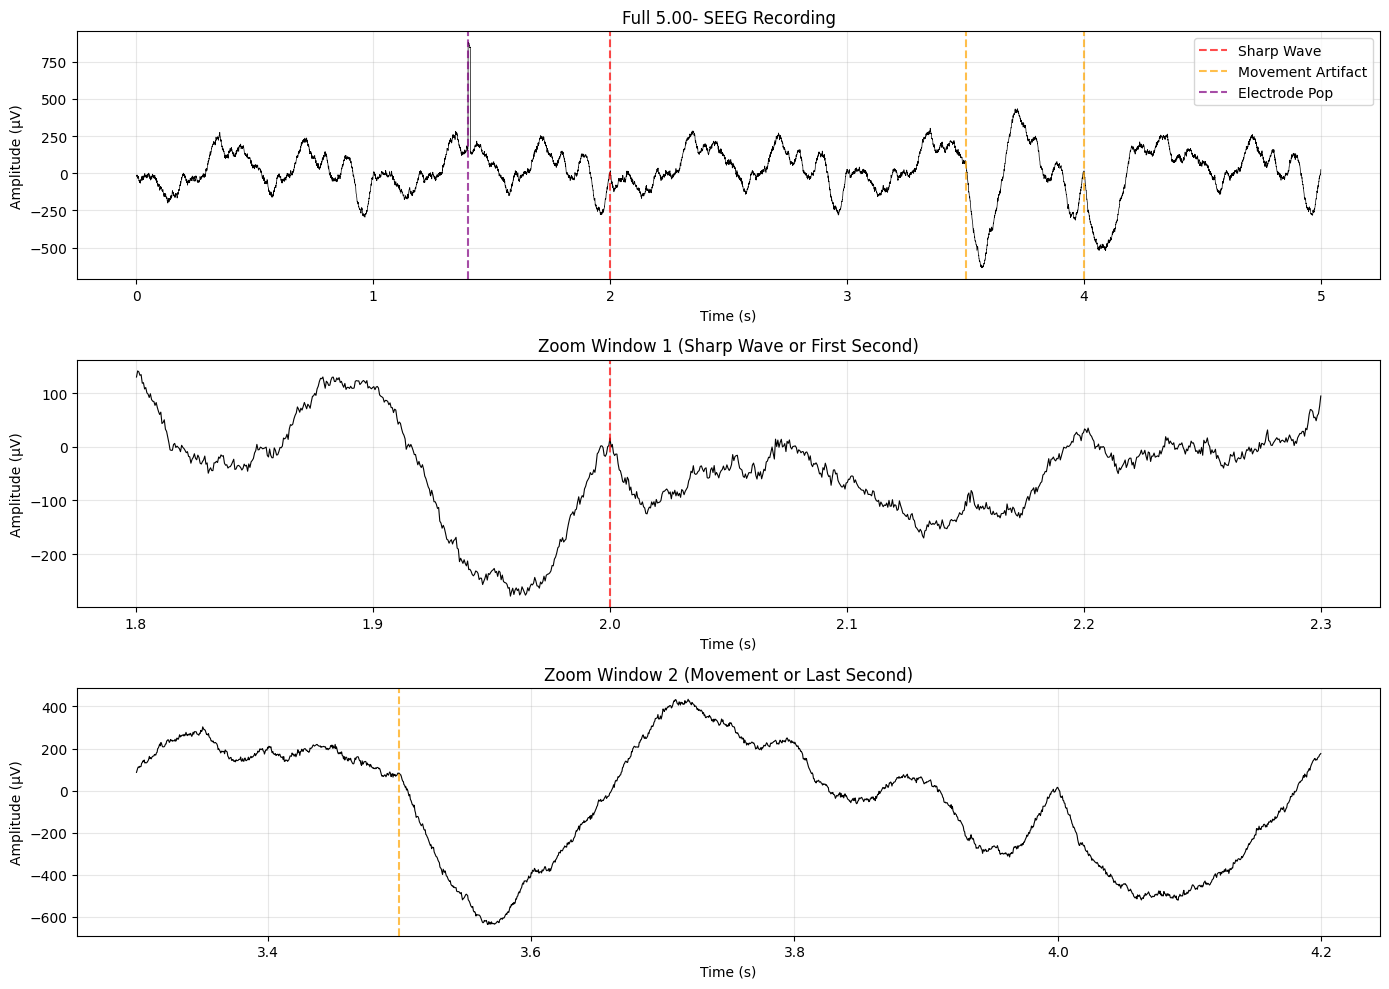

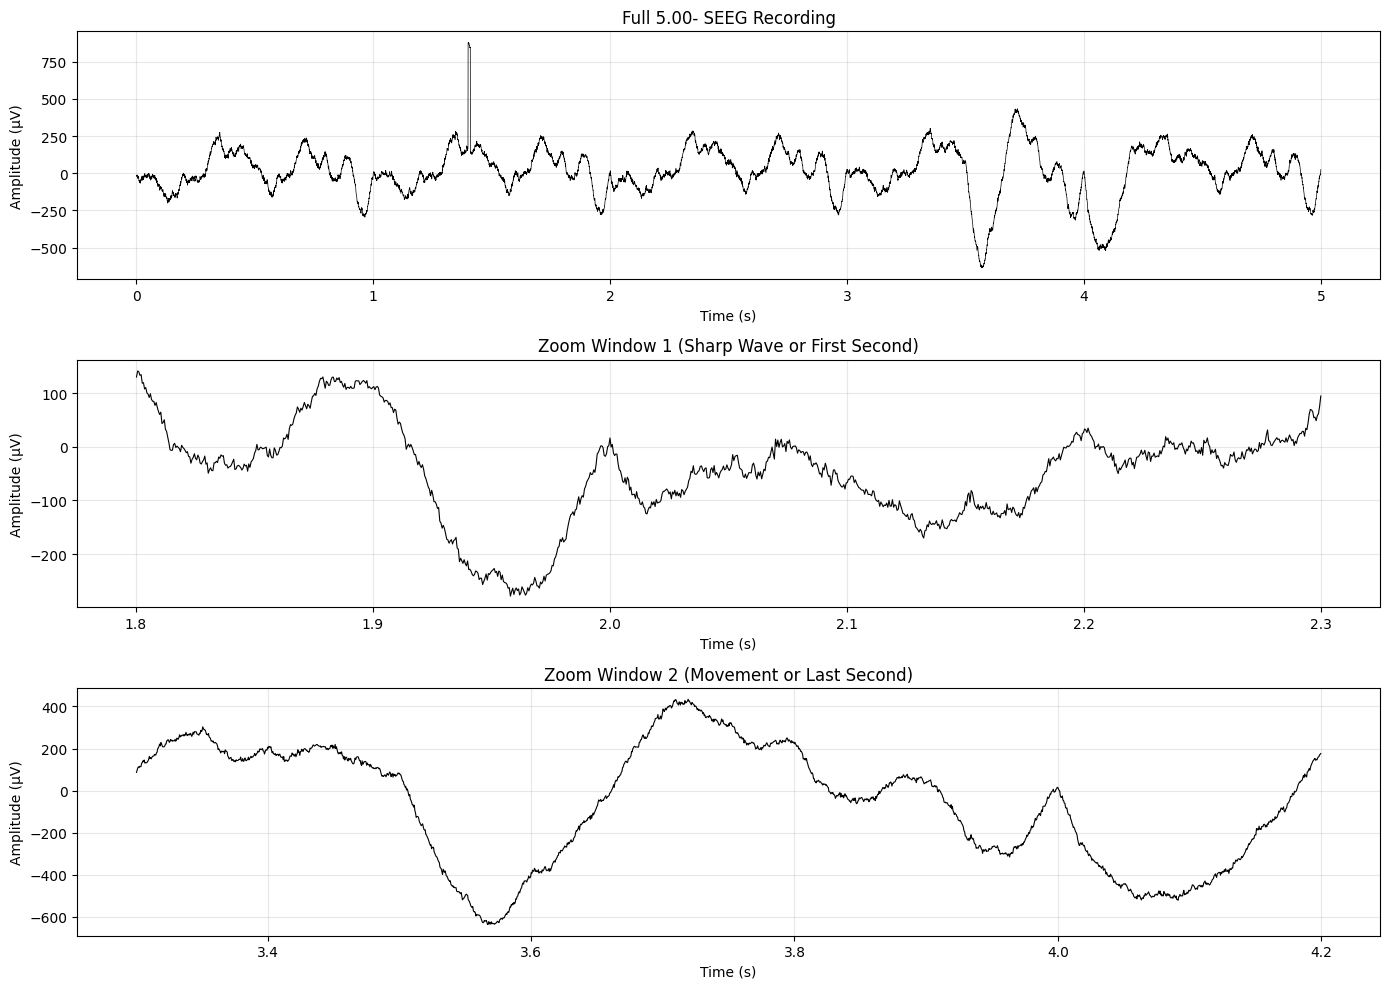

{'sampling_rate': 2048.0, 'units': 'µV', 'electrode_type': 'depth electrode', 'recording_type': 'SEEG', 'duration_sec': 5.0, 'filter_applied': 'none (raw)'}

GROUND TRUTH DESCRIPTION

📊 PHYSIOLOGICAL COMPONENTS:
  • DELTA: 0.5–4 Hz, ~80 µV
  • THETA: 4–8 Hz, ~40 µV
  • ALPHA: 8–13 Hz, ~30 µV
  • BETA: 13–30 Hz, ~15 µV
  • GAMMA: 30–80 Hz, ~5 µV
  • broadband_noise: {'amplitude_rms_uv': 10}

⚠️  PATHOLOGICAL ACTIVITY:
  • sharp_wave: t=2.0s, -180 µV, 70 ms - interictal epileptiform discharge

🚨 ARTIFACTS:
  • movement: at times [3.5, 4] ... (2 occurrences)
  • electrode_pop: at times [1.4] ... (1 occurrences)

📡 NOISE SOURCES:
  • 60 Hz line noise amplitude: 8.0 µV
  • Harmonics: [120, 180] Hz
  • Baseline drift amplitude: 30 µV
  • Impedance noise amplitude: 5 µV



In [2]:
from synthetic_neuraldata import (
    generate_seeg_data,
    plot_seeg,
    print_ground_truth
)

# =======================================================
# 1. Generate synthetic SEEG data
# =======================================================

raw, metadata, truth = generate_seeg_data(
    duration=5.0,
    sampling_rate=2048.0,
    include_ecg=False,
    include_sharp_wave=[2.0],
    include_movement=[3.5, 4],
    movement_amplitude_uv=800.0,                
    include_electrode_pop=[1.4],          
    electrode_pop_amplitude_uv=700.0,     
)

# =======================================================
# 2. Plot the SEEG signal
# =======================================================

plot_seeg(
    raw=raw,
    t=np.arange(0, metadata["duration_sec"], 1.0 / metadata["sampling_rate"]),
    artifact_times=truth["artifacts"],
    sharp_wave_time=truth["pathological_activity"]
                        .get("sharp_wave", {})
                        .get("time_sec", None),
    movement_duration_sec=0.5,
    show_artifact_lines=True,    # turn colored lines on/off
    show_legend=True,            # legend on/off
    show=True,                   # display figure window
)

plot_seeg(
    raw=raw,
    t=np.arange(0, metadata["duration_sec"], 1.0 / metadata["sampling_rate"]),
    artifact_times=truth["artifacts"],
    sharp_wave_time=truth["pathological_activity"]
                        .get("sharp_wave", {})
                        .get("time_sec", None),
    movement_duration_sec=0.5,
    show_artifact_lines=False,    # turn colored lines on/off
    show_legend=False,            # legend on/off
    show=True,                   # display figure window
)
# =======================================================
# 3. Print the ground truth information
# =======================================================

print(metadata)
print_ground_truth(truth)

In [12]:
# ---------- 12. Example usage ----------

if __name__ == "__main__":
    app = build_inspection_graph()

    # Synthetic neural data 
    initial_state: InspectionState = {
        "goal": "initial inspection of data to identify noise/artifact and determine whether the data is usable",
        "raw_data": raw.tolist(),
        "metadata": metadata
    }

    def safe_serialize(obj):
        if hasattr(obj, "model_dump"):
            return safe_serialize(obj.model_dump())
        if isinstance(obj, np.ndarray):
            return f"np.ndarray(shape={obj.shape})"
        if isinstance(obj, list):
            if len(obj) > 50:   # truncate long lists
                return f"[...{len(obj)} items...]"
            return [safe_serialize(v) for v in obj]
        if isinstance(obj, dict):
            return {k: safe_serialize(v) for k, v in obj.items()}
        return obj

    print("=== DEBUG STREAM OF PIPELINE ===")

    for event in app.stream(initial_state):
        print("\n--- NODE:", event["node"] if "node" in event else "UNKNOWN", "---")
        print(json.dumps(safe_serialize(event), indent=2))


=== DEBUG STREAM OF PIPELINE ===

--- NODE: UNKNOWN ---
{
  "planner": {
    "planner_output": {
      "calls": [
        {
          "tool": "plot_raw_signal_tool",
          "args": {
            "sampling_rate": 2048.0,
            "t_max": 5.0,
            "label": "Raw SEEG Signal"
          },
          "rationale": "Plotting the raw signal allows for a visual inspection of the data to identify any obvious noise or artifacts. Given the short duration of 5 seconds, the entire signal can be plotted for a comprehensive view."
        },
        {
          "tool": "compute_fft",
          "args": {
            "sampling_rate": 2048.0,
            "max_freq": 100.0,
            "db_scale": true,
            "make_plot": true,
            "label": "FFT Spectrum"
          },
          "rationale": "The FFT provides a frequency domain view of the signal, which can help identify noise or artifacts at specific frequencies. Limiting the max frequency to 100 Hz focuses on the most relevant

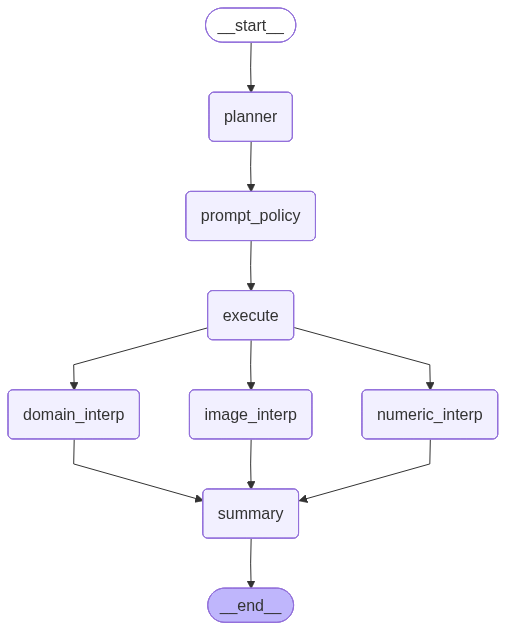

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Failed to display graph: {str(e)}")